# Table of Contents:
[I. Introduction](#I.-Introduction)<br><br>
[II. Examine and Explore data](#II.-Examine-and-Explore-data)<br>
[2a. Prepare data](#2a.-Prepare-data)<br>
[2b. Examine data](#2b.-Examine-data)<br>
[2c. Checking and Handling Missing Values](#2c.-Checking-and-Handling-Missing-Values)<br>
[2d. Choosing "Features"](#2d.-Choosing-"Features")<br><br>
[III. Apply the model for prediction with holdout and cross validation](#III.-Apply-the-model-for-prediction-with-holdout-and-cross-validation)<br><br>
[IV. Using PCA, apply the model with holdout and cross validation](#IV.-Using-PCA,-apply-the-model-with-holdout-and-cross-validation)<br><br>
[V. Analysis for each section](#V.-Analysis-for-each-section)<br><br>
[VI. Changing model](#VI.-Changing-model)<br><br>
[VII. Conclusions](#VII.-Conclusions)<br><br>
[VIII. References](#VIII.-References)

## I. Introduction
Sử dụng dữ liệu để tạo ra model (Linear Regression) để tiên đoán giá nhà. Dự án này đi theo những bước sau:<br>
- Kiểm tra và khám phá dữ liệu ( minh họa, tương tác trong các features)
- Ứng dụng model để tiên đoán với holdout và cross validation
- Sử dụng PCA, ứng dụng model với holdout và cross validation
- Minh họa phần dư (residue)
- Tune model nếu cần thiết
- Viết phân tích cho mỗi phần (ví dụ giải thích tại sao model bị overfitting, giải thích tại sao áp dụng PCA thì tốt hơn, vâng vâng...)
- Bao gồm các kết luận cho tổng kết

## II. Examine and Explore data

### 2a. Prepare data
<br>
**Import những libraries cần thiết và tải dữ liệu**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [52]:
df = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


### 2b. Examine data

In [53]:
df.shape

(63023, 13)

Trong khi dữ liệu có 63.023 observations và 13 features

In [54]:
df.describe()

,Rooms,Price,Postcode,Propertycount,Distance
count,63023.000000,4.843300e+04,63023.000000,63023.000000,63023.000000
mean,3.110595,9.978982e+05,3125.673897,7617.728131,12.684829
std,0.957551,5.934989e+05,125.626877,4424.423167,7.592015
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
25%,3.000000,6.200000e+05,3056.000000,4380.000000,7.000000
50%,3.000000,8.300000e+05,3107.000000,6795.000000,11.400000
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000
max,31.000000,1.120000e+07,3980.000000,21650.000000,64.100000


Hàng **count** thể hiện số dòng không bị missing value.<br>
Missing value có thể do nhiều lý do, chẳng hạn nhà có 2 phòng ngủ thì sẽ không thể thu thập được khi khảo sát nhà có 1 phòng ngủ.<br>
Hàng **mean** để đo độ trung bình, còn **std** là độ lệch chuẩn đo lường độ trải dài của dữ liệu.<br>
Diễn dịch min, 25%, 50%, 75%, max để chỉ ra số giá trị ở vị trí thấp nhất, mức 25%, 50%, 75%, cao nhất.

In [55]:
df.describe(include='O')

,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea
count,63023,63023,63023,63023,63023,63023,63023,63023
unique,380,57754,3,9,476,112,8,34
top,Reservoir,3 Donald St,h,S,Barry,24/03/2018,Southern Metropolitan,Boroondara City Council
freq,1241,7,45053,34063,6894,1144,17559,5132


### 2c. Checking and Handling Missing Values

imputation, phan tich tung cot va thay the. Numerical for mean , category for frequently/unknown

In [56]:
# Check to see if there are any missing values in our data set
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Price    14590
dtype: int64


Có **14.590 hàng** bị thiếu **price**

In [57]:
round(14590/63023*100, 2)

23.15

Dữ liệu bị thiếu chiếm **23.15%**

In [58]:
df['Price'].mean()

997898.2414882415

**Fix missing values**<br>
Ý tưởng: 
- Tạo 1 bộ dữ liệu mới (new_data)
- Tìm mean của Price feature
- Fill mean thay cho các NA ở bộ dữ liệu mới đó
- Check lại lần nữa

In [59]:
new_data = df.copy() # shallow copy
n = df['Price'].mean()
new_data['Price'] = new_data['Price'].fillna(value=n)
missing_val_count_by_column = (new_data.isnull().sum()) # Check again
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


Dữ liệu giờ hết missing values!

**Kiểm tra độ tin cậy của dữ liệu**

In [60]:
new_data.describe(percentiles=[.25, .5, .75, .85, .90, .99])

,Rooms,Price,Postcode,Propertycount,Distance
count,63023.000000,6.302300e+04,63023.000000,63023.000000,63023.000000
mean,3.110595,9.978982e+05,3125.673897,7617.728131,12.684829
std,0.957551,5.202835e+05,125.626877,4424.423167,7.592015
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
25%,3.000000,6.770000e+05,3056.000000,4380.000000,7.000000
50%,3.000000,9.978982e+05,3107.000000,6795.000000,11.400000
75%,4.000000,1.065000e+06,3163.000000,10412.000000,16.700000
85%,4.000000,1.336850e+06,3187.000000,11918.000000,20.000000
90%,4.000000,1.550000e+06,3194.000000,14577.000000,21.500000
99%,5.000000,3.000000e+06,3756.000000,21650.000000,38.000000


Ta có dữ liệu mới với giá nhà trung bình 9.978982e+05, 3 phòng, khoảng cách là 12.68 km, Propertycount là 7617.72<br>
Trong đó ta thấy một điều đáng chú ý, là có căn có đến **31** phòng. Dù ở mức 99% là 5 phòng.

In [61]:
new_data[new_data['Rooms'] >= 31]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
55467,Wantirna South,5 Cottswold Pl,31,h,990000.0,S,Justin,27/06/2016,3152,Eastern Metropolitan,7082,14.7,Knox City Council


Ta thấy cái căn này có 31 phòng có giá thấp hơn mức trung bình, khoảng cách và Propertycount tương đương. Nên đây là dữ liệu sai lệch.<br>
Vì thế ta sẽ drop row này đi.

In [62]:
new_data= new_data.drop([55467], axis=0)
new_data.describe()

,Rooms,Price,Postcode,Propertycount,Distance
count,63022.000000,6.302200e+04,63022.000000,63022.000000,63022.000000
mean,3.110152,9.978984e+05,3125.673479,7617.736632,12.684797
std,0.951092,5.202876e+05,125.627830,4424.457755,7.592071
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
25%,3.000000,6.770000e+05,3056.000000,4380.000000,7.000000
50%,3.000000,9.978982e+05,3107.000000,6795.000000,11.400000
75%,4.000000,1.065000e+06,3163.000000,10412.000000,16.700000
max,16.000000,1.120000e+07,3980.000000,21650.000000,64.100000


**Price visualization**

Biểu đồ theo giá tiền, số phòng và loại nhà

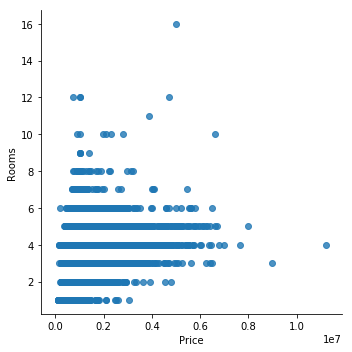

In [63]:
sns.lmplot(x='Price', y='Rooms', data=new_data,
          fit_reg=False) # No regression line
          #hue='Type')   # Color by evolution stage)

Với h: house , t: townhouse, u: unit

Không phải nhà nào càng nhiều phòng thì giá cũng cao

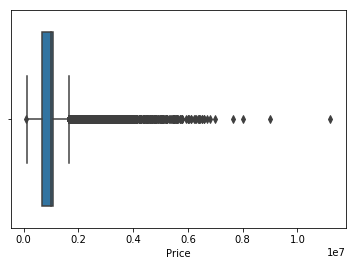

In [64]:
sns.boxplot(new_data['Price'])

### 2d. Choosing "Features"

In [65]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63022 entries, 0 to 63022
Data columns (total 13 columns):
Suburb           63022 non-null object
Address          63022 non-null object
Rooms            63022 non-null int64
Type             63022 non-null object
Price            63022 non-null float64
Method           63022 non-null object
SellerG          63022 non-null object
Date             63022 non-null object
Postcode         63022 non-null int64
Regionname       63022 non-null object
Propertycount    63022 non-null int64
Distance         63022 non-null float64
CouncilArea      63022 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 6.7+ MB


Dữ liệu dạng category:
- Suburb
- Address
- Type
- Method
- SellerG
- Date
- Regionname
- CouncilArea
- Postcode

Còn lại là dữ liệu dạng số: Rooms, Price, Propertycount, Distance 

**Xem tính tương quan giữa các features dạng số**

In [66]:
melbourne_features = ['Rooms', 'Price', 'Propertycount', 'Distance', 'Postcode']

In [67]:
X = new_data[melbourne_features]

In [68]:
X.describe()

,Rooms,Price,Propertycount,Distance,Postcode
count,63022.000000,6.302200e+04,63022.000000,63022.000000,63022.000000
mean,3.110152,9.978984e+05,7617.736632,12.684797,3125.673479
std,0.951092,5.202876e+05,4424.457755,7.592071,125.627830
min,1.000000,8.500000e+04,39.000000,0.000000,3000.000000
25%,3.000000,6.770000e+05,4380.000000,7.000000,3056.000000
50%,3.000000,9.978982e+05,6795.000000,11.400000,3107.000000
75%,4.000000,1.065000e+06,10412.000000,16.700000,3163.000000
max,16.000000,1.120000e+07,21650.000000,64.100000,3980.000000


,Rooms,Price,Propertycount,Distance,Postcode
Rooms,1.000000,0.359141,-0.049262,0.269990,0.094205
Price,0.359141,1.000000,-0.053670,-0.221145,0.002726
Propertycount,-0.049262,-0.053670,1.000000,0.014050,-0.002557
Distance,0.269990,-0.221145,0.014050,1.000000,0.500262
Postcode,0.094205,0.002726,-0.002557,0.500262,1.000000


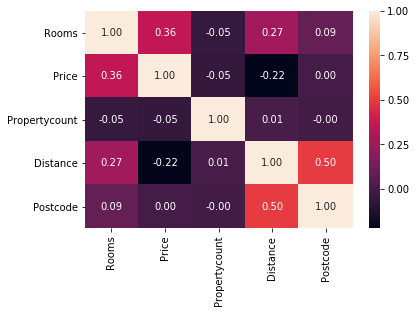

In [69]:
corr = X.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, fmt=".2f")

corr

Ta thấy độ tương quan của Propertycount rất thấp -> drop cột này đi<br>
Còn những dữ liệu dạng category ở trên thì bỏ: Address, Postcode

In [70]:
data_after_chose = new_data[['Rooms', 'Price', 'Distance', 'Postcode']]
data_after_chose.describe()

,Rooms,Price,Distance,Postcode
count,63022.000000,6.302200e+04,63022.000000,63022.000000
mean,3.110152,9.978984e+05,12.684797,3125.673479
std,0.951092,5.202876e+05,7.592071,125.627830
min,1.000000,8.500000e+04,0.000000,3000.000000
25%,3.000000,6.770000e+05,7.000000,3056.000000
50%,3.000000,9.978982e+05,11.400000,3107.000000
75%,4.000000,1.065000e+06,16.700000,3163.000000
max,16.000000,1.120000e+07,64.100000,3980.000000


## III. Apply the model for prediction with holdout and cross validation

In [71]:
# Columns to use for trainning
X = data_after_chose.drop(['Price'], axis=1)
# Column target
y = data_after_chose['Price']

**Holdout**

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
model = LinearRegression()

In [25]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_pred = model.predict(X_test)

**Residual plot**

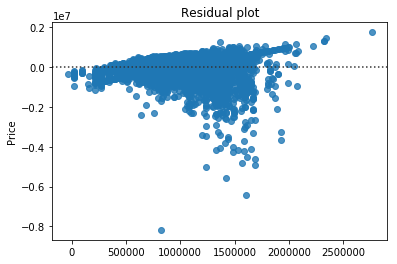

In [28]:
#Residual plot
plt.title('Residual plot')
plt.ylabel('Residual')
sns.residplot(y_pred, y_pred - y_test)

In [30]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

299850.57900882367

**MAE** khi dùng holdout là **299850.57**

**Cross validation**

<img src="https://i.stack.imgur.com/1fXzJ.png" alt="Alt text that describes the graphic" title="Title text" />

Chúng ta chạy model qua những subset để lấy được sự đo lường chất lượng của model trong nhiều lần. Với K-folds = 5, chúng ta chia dữ liệu làm 5 mảnh, mỗi mảnh ứng với 20% của toàn bộ dữ liệu.

Chọn model LinearRegression, đo lường độ hiệu quả bằng **MAE** mean absolute error, và dùng cross validation.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from time import perf_counter

In [38]:
t0 = perf_counter()
kfold = KFold(n_splits=5)
scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=kfold)
t1 = perf_counter()
print("MAE scores:", scores.mean()*(-1))
print("Chạy mất {0:.4f} giây.".format(t1-t0))

MAE scores: 299620.1651022321
Chạy mất 0.0417 giây.


Scikit-learn có quy ước, các đo lường (metrics) được định ra thì con số nào cao hơn thì tốt hơn. Sử dụng negative (âm) ở đây cho nhất quán với cái quy ước mặc dù **MAE** thì không có số âm.<br>
Khi ta đã trung bình scores và đổi về **số dương** thì lúc này cái nào thấp hơn thì mô hình đó tốt hơn.

Giá nhà ở mức _trung bình_ là **1 triệu đô**, và phần sai số tuyệt đối trung bình là **300.000**. Ta thấy kết quả hợp lý trong thực tế.

kết luận:
- MAE khi holdout **299850.57** và MAE khi cross validation là **299620.16**
- 2 kết quả này không đồng nhất với nhau. Chứng tỏ trên các subset khác nhau thì đưa ra các kết quả khác nhau.
- Vì ở cross validation dùng kfold với 5 folds nên kết quả ở phần này đáng tin cậy hơn

## IV. Using PCA, apply the model with holdout and cross validation

**PCA**

In [41]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=3)
pca.fit(X)
new_X = pca.transform(X)

**Holdout**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

In [44]:
model_with_pca = LinearRegression()

In [46]:
model_with_pca.fit(X_train, y_train)
predict_with_pca = model_with_pca.predict(X_test)

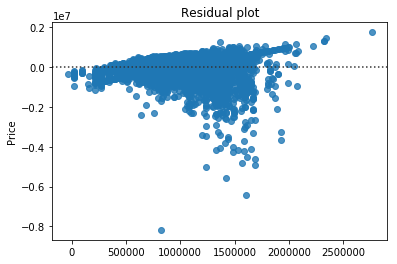

In [47]:
#Residual plot
plt.title('Residual plot')
plt.ylabel('Residual')
sns.residplot(predict_with_pca, predict_with_pca - y_test)

In [48]:
mean_absolute_error(y_test, predict_with_pca)

299850.5790088236

**MAE** ở đây là **299850.58**

**Cross validation**

In [50]:
t2 = perf_counter()
kfold = KFold(n_splits=5)
scores = cross_val_score(LinearRegression(), new_X, y, scoring='neg_mean_absolute_error', cv=kfold)
t3 = perf_counter()
print("MAE score:", scores.mean()*(-1))
print("Chạy mất {0:.4f} giây.".format(t3-t2))

MAE score: 299620.1651022322
Chạy mất 0.0316 giây.


Kết luận: Vậy là nếu dùng PCA thì số chiều nhỏ hơn và train cũng nhanh hơn

## V. Analysis for each section

(# **Old** Analysis)<br>
Ứng dụng model cho dự đoán, dùng _holdout_ nhưng **không** dùng PCA:
- Mean Absolute Error: **298754.55**

Ứng dụng model cho dự đoán, dùng _holdout_ **có dùng** PCA: (chọn n components = **3**)
- Mean Absolute Error: **301964.58**

Ứng dụng model cho dự đoán, dùng _cross validation_ nhưng **không** dùng PCA:
- Mean Absolute Error: **299620.165102**
- Elapsed time: **0.1981** seconds

Ứng dụng model cho dự đoán, dùng _cross validation_ **có dùng** PCA: (chọn n components = **3**)
- Mean Absolute Error: **299620.165102**
- Elapsed time: **0.1326** seconds

Kết luận:
- Trong những mô hình có dữ liệu **nhỏ** mà ta vẫn chưa chắc về model thì nên dùng _cross validation_, trong những mô hình có dữ liệu lớn thì _holdout_ là một giải pháp tốt hơn.
- Khi chọn với số components là 3 thì **MAE** của 2 model đều **bằng nhau** (trong cross validation). Tuy nhiên nếu chọn số chiều thấp hơn ( ví dụ components = 2) thì **MAE** của model **_không dùng PCA_** nhỏ hơn -> chứng tỏ model **không dùng PCA lúc này** dự đoán **tốt hơn**
- Về thời gian chạy, kể cả khi **MAE** của 2 model bằng nhau thì model **có dùng PCA** chạy **nhanh hơn**. 
<br>
Số chiều càng nhỏ thì model train càng nhanh hơn nhưng thiếu chính xác hơn.

In [88]:
pca = PCA(n_components=2)
pca.fit(X)
new_X_1 = pca.transform(X)
t4 = perf_counter()
scores = cross_validate(LinearRegression(), new_X_1, y, scoring='neg_mean_absolute_error', cv=5)
t5 = perf_counter()
print(scores)
print("Chạy mất {0:.4f} giây.".format(t5-t4))

{'fit_time': array([0.00800014, 0.00900054, 0.00800061, 0.0090003 , 0.00800037]), 'score_time': array([0.00100017, 0.00099993, 0.00100017, 0.00200033, 0.00099993]), 'test_score': array([-321594.1918956 , -325747.44970179, -325793.57623815,
       -322581.19051405, -331318.99634996])}
Chạy mất 0.0559 giây.


In [89]:
print('Mean Absolute Error %2f' %(-1 * scores['test_score'].mean()))

Mean Absolute Error 325407.080940


## VI. Changing model

Biết đâu mô hình này vẫn chưa đủ tốt. Ta dùng thử mô hình KNN regressor cho bài toán dự đoán giá nhà này.

In [73]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [74]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

269894.85087554745

Ta thấy MAE của khi qua mô hình mới đã giảm nhỏ nhất so với mô hình Logistic Regression ở trên. Giờ ta thử với Kfold xem thử kết quả này có ổn định hay không?

In [77]:
scores = cross_val_score(KNeighborsRegressor(), X, y, scoring='neg_mean_absolute_error' ,cv=kfold)
print("MAE score:", scores.mean()*(-1))

MAE score: 265893.9134619547


Kết quả khá tốt, MAE trung bình (cross validation) của mô hình này thấp hơn so với mô hình Logistic Regression ở trên.

## VII. Conclusions

- Sau khi khám phá dữ liệu ta thấy có lượng missing value lớn, thuộc column Price chiếm **23.15%** quan sát. Đây là một lượng dữ liệu lớn nên ta xử lý bằng cách fill các missing value này bằng giá trị **mean** của column Price này. Sau đó quan sát thấy các dữ liệu bất thường về số phòng Rooms nên ta drop các hàng này.
- Sau khi ứng dụng model để tiên đoán với holdout và cross validation, không dùng và có dùng PCA. Ta nhận thấy khi dùng PCA thì **thời gian** xử lý dữ liệu **nhanh hơn**, với _chiều PCA **càng nhỏ**_ thì _trung bình sai số tuyệt đối **tăng lên**_.

## VIII. References

[Cross-Validation by DanB](https://www.kaggle.com/dansbecker/cross-validation)<br>
[Handling Missing Values by DanB](https://www.kaggle.com/dansbecker/handling-missing-values)